# Astronomy Software Benchmarking 

## Introduction:

#### The Problem:

We want to model quasar winds through synthetic spectra however this takes a great deal of time. One reason is that statisical modeling is a computationally intesen process, this can't be changed. The other reason, however, is that many of the rate-limiting steps are written in python, which is very slow and takes a great deal of memory.

#### Possible Solutions: 

There are several python packages that could be imported to replace certain python codes and speed up the process. We could also cut out the middle man and entirely rewrite the code in C or C++ , which can be far more efficiently compiled. 

## Simple Python: 

Before we can improve the spectra generations we first want to make a standard to compare it to in simple python code:


#### First we generate a simple list of wavelengths

In [1]:
# Importing simple packages
import matplotlib.pyplot as plt
import numpy as np

# Importing benchmarking tool
import time

In [2]:
# Specify needed items.

# Start, end wavelength for the spectrum and number of points
startw = 900.       # Angstroms
finalw = 2900.
nspect = 2048

# Number of lines in the spectrum model
nlines = 1000

# Width of each line in gaussian sigma, in Angstroms
lsigma = 4.0

# Width of halfnormal distribution.  We use a halfnormal distribution
# of line depths so most are near zero and only a few are much larger.
halfsig = 0.1

In [3]:
# Generate a wavelength list for the spectrum.
wavels = np.linspace(startw, finalw, nspect, endpoint=True)

#### Next we create a list of wavelengths AND line depths in order to synthesize a spectrum.

In [11]:
# Generate list of line depths and fix up so none are > 1.0
# We want the absolute value of a normal distribution

depths = np.absolute(np.random.normal(0.0, halfsig, nlines))
depths[depths > 1.0] = 1.0
print(depths)

# Generate a list of line wavelengths, which we take as
# uniformly distributed over the spectrum
lwaves = np.random.uniform(startw, finalw, nlines)
print(lwaves)

[4.24014553e-02 6.11991074e-02 1.10091195e-02 1.17398984e-01
 2.48226798e-03 2.05930444e-01 7.59584769e-02 1.73088565e-02
 1.49032760e-01 3.97971276e-02 4.37848217e-02 1.06067181e-01
 9.91855086e-02 1.65786339e-01 1.62353184e-01 1.71763859e-02
 8.65940413e-02 5.76651435e-02 1.76840906e-01 3.37038352e-02
 1.73588806e-02 2.70545821e-02 1.03202464e-01 1.14959098e-01
 1.04873074e-01 4.17684611e-02 1.30564742e-01 9.01583051e-02
 1.94688065e-01 1.34043668e-01 1.95776438e-01 5.72887482e-02
 1.38977861e-01 4.45639345e-02 7.74764048e-02 6.14525866e-02
 1.62428718e-01 8.52512581e-02 3.08161403e-02 8.27255812e-02
 6.36363369e-03 2.05707762e-02 2.96701896e-02 1.50012140e-02
 1.21084151e-01 1.31768428e-01 1.06353650e-01 2.09603909e-01
 2.66025593e-02 7.13251227e-02 1.41000761e-02 6.78451761e-02
 2.67245443e-02 1.00309925e-01 2.39749961e-01 4.54990138e-02
 2.09956737e-02 4.55016134e-03 1.50037772e-02 4.74782983e-02
 1.33201916e-01 2.64921452e-02 6.02261500e-03 1.11501104e-01
 1.23392036e-01 4.349496

In [13]:
# Function to return an I/Io spectrum, meaning a spectrum normalized so
# the continuum is 1 everywhere.
def blankspec(npts):
    """
    docstring here
    """
    B = [1.0 for n in range(npts)]
    return B

# Gauss function
from numpy import exp
def gauss(w, cent, depth, sigma):
    """
    docstring here
    """
    gval = -depth * exp(-(w - cent)**2 / 2.0 / sigma**2)
    return gval

In [14]:
# Test with a single line
linecenter = 2023.9
linedepth  = 0.4

blank = blankspec(nspect)
spect = []
for k in range(len(wavels)):
    w = wavels[k]
    d = gauss(w, linecenter, linedepth, lsigma)
    s = blank[k] + d
    spect.append(s)

Text(0, 0.5, 'Spectrum')

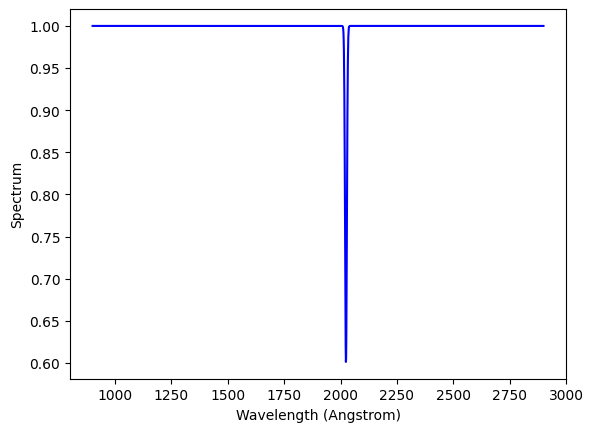

In [15]:
fig, ax = plt.subplots()
ax.plot(wavels, spect, 'blue')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Spectrum')

#### Now we want to make a Full Spectrum

We will do this by 
1. Generating a spectrum with a single line for each line in the list
2. Multiplying all of these spectrums together


In [16]:
# Generate a spectrum with a single line, if there are N lines in the list you get N spectra
def genspec(wavels, lwave, depth, lsigma):
    blank = blankspec(len(wavels))
    spect = []
    for k in range(len(wavels)):
        w = wavels[k]
        d = gauss(w, lwave, depth, lsigma)
        s = blank[k] + d
        spect.append(s)
    return spect

spectrums = []
for N in range(nlines):
    lwave = lwaves[N]
    depth = depths[N]
    spectrums.append(genspec(wavels, lwave, depth, lsigma))
    #plt.plot(wavels, spect, 'blue')
    #plt.show()

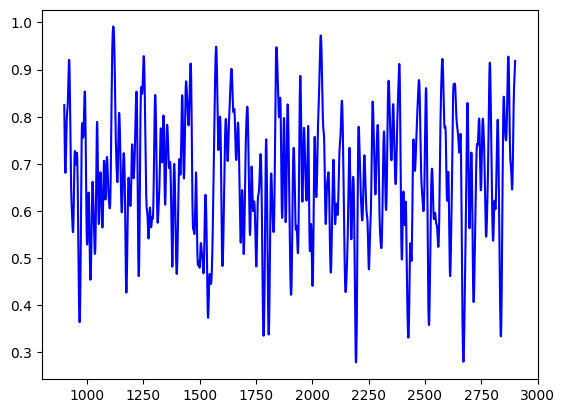

In [17]:
start_time_py = time.perf_counter()

# Multiply all the spectra together
final = spectrums[0]
for k in range(1, len(spectrums)):
    final = [final[n] * spectrums[k][n] for n in range(len(final))]
end_time_py = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()

## Now with Numpy: 

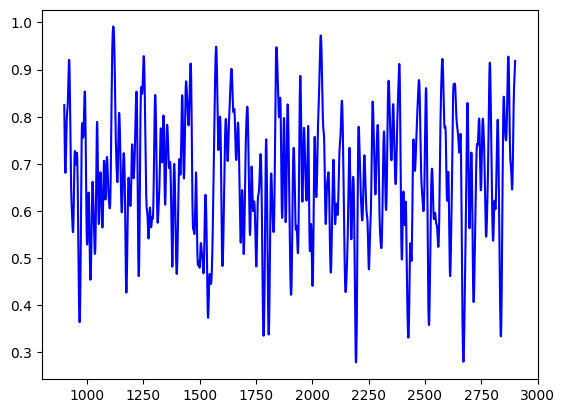

In [18]:
start_time_np = time.perf_counter()
# Multiply all the spectra together with numpy
final = spectrums[0]
for k in range(1, len(spectrums)):
    final = np.multiply(final, spectrums[k])
end_time_np = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()

In [19]:
print("Python time: ", end_time_py - start_time_py)
print("Numpy  time: ", end_time_np - start_time_np)

Python time:  0.5007252140203491
Numpy  time:  0.18415830697631463


## Now with Math Prod

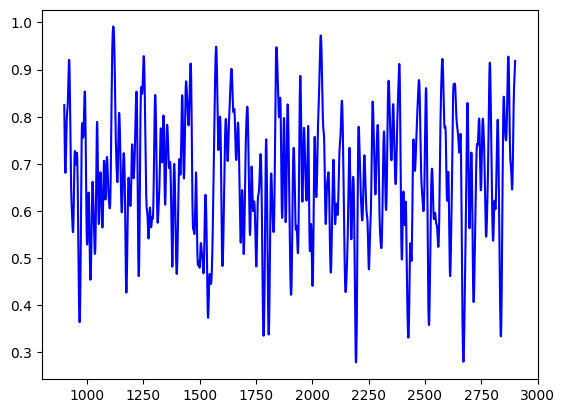

In [22]:

# Python3 program to multiply all values in the
# list using math.prod
 
import math
 
start_time_mp = time.perf_counter()
# Multiply all the spectra together with math
final3 = spectrums[0]
for k in range(1, len(spectrums)):
    final3 = math.prod( spectrums[k])
end_time_mp = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()

In [23]:
print("Python time: ", end_time_py - start_time_py)
print("Numpy  time: ", end_time_np - start_time_np)
print("Math  time:", end_time_mp - start_time_mp)

Python time:  0.5007252140203491
Numpy  time:  0.18415830697631463
Math  time: 0.9056789000169374


## Now with mul *

In [24]:

# Python 3 program to multiply all numbers in
# the given list by importing operator module
 
from operator import*

start_time_mu = time.perf_counter()
m = 1
for i in range(1, len(spectrums)):
  # multiplying all elements in the given list 
  # using mul function of operator module
    m = mul(i, m)

end_time_mu = time.perf_counter()
# printing the result
#print(m)


In [25]:
print("Python time: ", end_time_py - start_time_py)
print("Numpy  time: ", end_time_np - start_time_np)
print("Math  time:", end_time_mp - start_time_mp)
print("Mult  time",end_time_mu - start_time_mu )

Python time:  0.5007252140203491
Numpy  time:  0.18415830697631463
Math  time: 0.9056789000169374
Mult  time 0.0021347329602576792


## Now with Reduce: 

In [ ]:
from functools import reduce
 
result1 = reduce((lambda x, y: x * y), list1)

final = spectrums[0]
for k in range(1, len(spectrums)):
    final = reduce(final, spectrums[k])
end_time_np = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()


In [ ]:

# Python3 program to multiply all values in the
# list using lambda function and reduce()
 
from functools import reduce
list1 = [1, 2, 3]
list2 = [3, 2, 4]
 
 
result1 = reduce((lambda x, y: x * y), list1)
result2 = reduce((lambda x, y: x * y), list2)
print(result1)
print(result2)
